In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import os
import scipy

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.applications import VGG16



from tensorflow.keras.layers import  Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2


We need to mount Google Drive to the Colab environment. So our Google Drive files will be accessible within Google Colab.

In [ ]:
# Importing drive module
from google.colab import drive
drive.mount('/content/drive')

To make trining process faste as we are creating Convolutiona Neural Network we need to to copy directory from mounted Google Drive to local storage in Google Colab environment.

In [ ]:
#importing shutil module
import shutil

# path to Google Drive source folder we are copying from
src_folder = '/content/drive/MyDrive/Data Fresh Rotten Fruits/dataset/dataset'

# Destination folder in Colab's local storage
dst_folder = '/content/copy_of_folder'

# Copy the folder from Google Drive to Colab's local storage
shutil.copytree(src_folder, dst_folder)


'/content/copy_of_folder'

In [ ]:
# paths to train and test folders      to use this code when we use path from google drive
train_folder = '/content/drive/MyDrive/Data Fresh Rotten Fruits/dataset/train'
test_folder = '/content/drive/MyDrive/Data Fresh Rotten Fruits/dataset/test'

In [ ]:
# paths to train and test folders     to use this code when we use path from google colab (to make train process fast we need to use this code)
#train_folder = '/content/copy_of_folder/train'
#test_folder = '/content/copy_of_folder/test'

We are using **ImageDataGenerator** to load, preprocess and augment training, validation, test datasets.   <br> We need to convert the pixel values which ranges from  0 to 255 to the scale of 0 to 1. This is also known as normalization. <br> When we train a Convolutional Neural Network we use gradient based optimization methods to adjust the weights by error which network gives on the training example. If we fit network actual pixels 0-255 larger values will result larger error and network will update the weights too quikly, making it hard for network to learn.


**ImageDataGenerator** helps to prepare dataset. It applies transformation in train images rescaling, shearing, zooming, flipping. This way we augment train dataset and generate more diverse training samples. <br> We need to specify a protion of training data to be used as a validation set . We have **10,451** images in **training dataset** from which **8723** is used as **training** and **2178** as **validation**.

The **train_datagen** is used to read images from the directory and later to feed the model. Method **flow_from_directory** allows us to read images directly from the directory (folder containing images). <br> **train_folder** this is the path to the directory. It contains one subdirectory per class. In this case we have 6 subdirectory. <br> **target_size** = (256,256) We choose dimension 255x255 all images will be resized. So every image we load will be resized by 255x255. <br> **color_mode** = 'rgb' images will be converted to have 3 color channels (reg, green, blue). <br> **batch_size** the size of the batches of data. So we don't feed entire dataset at once instead we feed it in batches. Ater each batch is run through the model the weights are updated. <br> **class_mode** determines type of labels. Here will be 2D one-hot encoded labels for a multi_class classification.<br> **subset** = 'training' subset of data to generate. We specified validation_split in ImageDataGenerator.

In [ ]:
# ImageDataGenerator for training set
train_datagen = ImageDataGenerator (
    # Rescaling Factor
    rescale = 1./255,
    # Shear Intensity shear angel in counter-clockwise direction in degrees
    shear_range = 0.2,
    # Range for random zoom
    zoom_range =0.2,
    # Randomly flips inputs horizontally
    horizontal_flip = True,
    # Randomly flips inputs vertically
    vertical_flip = True,
    # Fraction of images for validation
    validation_split=0.2
)

# ImageDataGenerator for test set
test_datagen = ImageDataGenerator (
    rescale = 1./255
)

# train
train_generator = train_datagen.flow_from_directory (
    # path to the directory
    train_folder,
    # dimension images resized
    target_size=(256,256),
    # channel size
    color_mode='rgb',
    # size of the batches of data
    batch_size=32,
    # type of labels
    class_mode='categorical',
    # subset of data
    subset='training',
    shuffle = True
 )
# validation
validation_generator = train_datagen.flow_from_directory (
    # path to the directory
    train_folder,
    # dimensions images resized
    target_size=(256,256),
    # channel size
    color_mode='rgb',
    # size of the batches of data
    batch_size=32,
    # type of labels
    class_mode='categorical',
    # subset of data
    subset='validation',
    shuffle = True
)

# test
test_generator = test_datagen.flow_from_directory (
    # path to the directory
    test_folder,
    # dimensions images resized
    target_size=(256,256),
    # channel size
    color_mode='rgb',
    # size of the batches of data
    batch_size=32,
    # type of labels
    class_mode='categorical',
    shuffle = False
)




Found 8723 images belonging to 6 classes.
Found 2178 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [ ]:
# number of batches in train_generator
len(train_generator)

273

In [ ]:
# number of batches in validation_generator
len(validation_generator)

69

In [ ]:
# number of batches in test_generator
len(test_generator)

85

Lets define a basic convolutional neural network (CNN)

In [ ]:

baseline = Sequential()

baseline.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
baseline.add(MaxPooling2D((2, 2)))

baseline.add(Conv2D(64, (3, 3), activation='relu'))
baseline.add(MaxPooling2D(2, 2))

baseline.add(Conv2D(128, (3, 3), activation='relu'))
baseline.add(MaxPooling2D((2, 2)))


baseline.add(Flatten())
baseline.add(Dense(64, activation='relu'))
baseline.add(Dense(6, activation='Softmax'))

baseline.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])


# New Section

In [ ]:
baseline.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 128)     

In [ ]:
history = baseline.fit(
    train_generator,
    steps_per_epoch = 10,
    epochs = 10,
    validation_data = validation_generator
)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 3.7634 - acc: 0.2031

In [ ]:
# Evaluate the model on the test data
test_results = baseline.evaluate(test_generator)

# The evaluate() method returns the test loss and test accuracy
test_loss = test_results[0]
test_accuracy = test_results[1]

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


85/85 [==============================] - 1055s 13s/step - loss: 0.8048 - acc: 0.6913
Test Loss: 0.8048
Test Accuracy: 0.6913


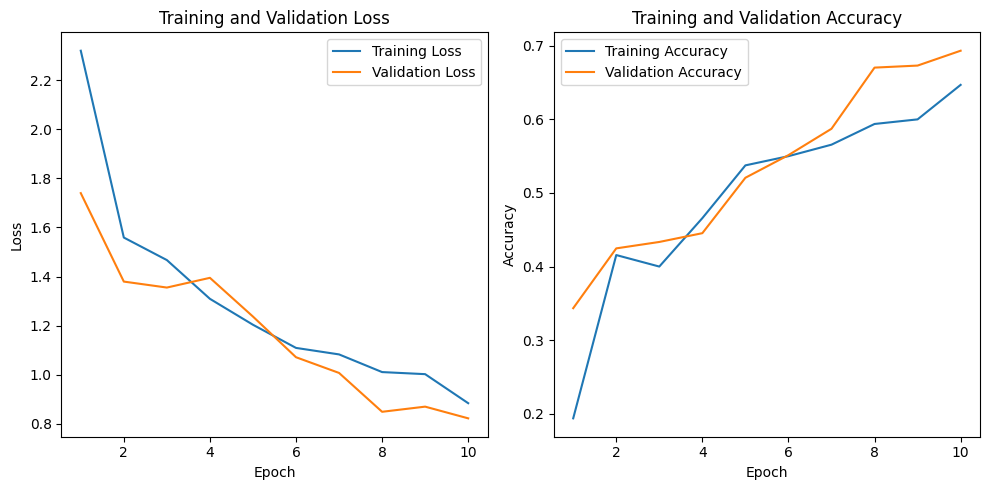

In [ ]:
# Get training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get training and validation accuracy values
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']

# Plot the loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


85/85 [==============================] - 134s 2s/step


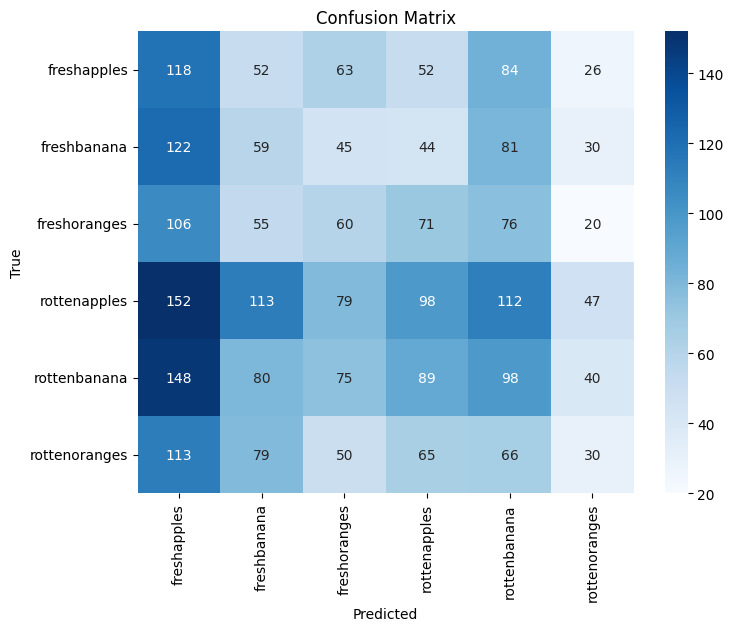

In [ ]:
# Make predictions on the test data
test_predictions = baseline.predict(test_generator)
predicted_classes = np.argmax(test_predictions, axis=1)

# Get the true labels from the test data generator
true_labels = test_generator.classes

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Get the class names from the test data generator
class_names = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Print the classification report
print(classification_report(true_labels, predicted_classes, target_names=class_names))

               precision    recall  f1-score   support

  freshapples       0.16      0.30      0.20       395
  freshbanana       0.13      0.15      0.14       381
 freshoranges       0.16      0.15      0.16       388
 rottenapples       0.23      0.16      0.19       601
 rottenbanana       0.19      0.18      0.19       530
rottenoranges       0.16      0.07      0.10       403

     accuracy                           0.17      2698
    macro avg       0.17      0.17      0.16      2698
 weighted avg       0.18      0.17      0.17      2698



In [ ]:
true_labels             # holds the true class labels for the test data


array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

In [ ]:
predicted_classes      #  holds the predicted class labels obtained from the model's predictions.

array([0, 3, 2, ..., 1, 0, 0])

1/1 [==============================] - 0s 64ms/step


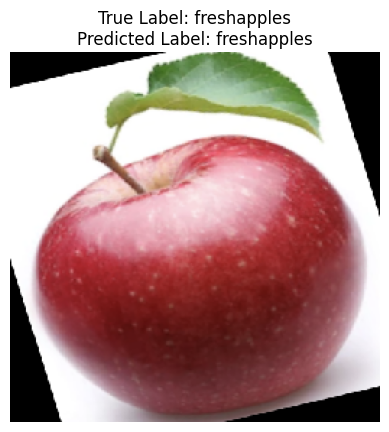

1/1 [==============================] - 0s 69ms/step


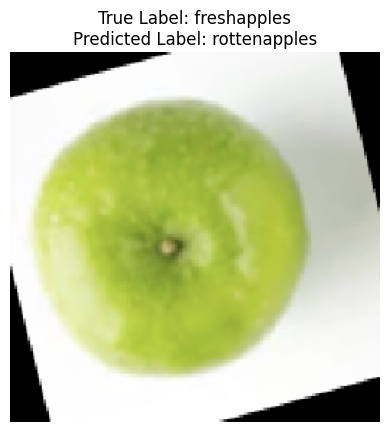

1/1 [==============================] - 0s 69ms/step


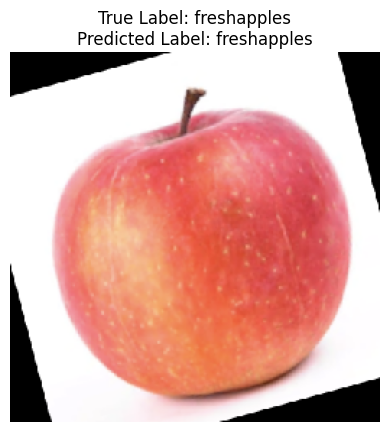

1/1 [==============================] - 0s 64ms/step


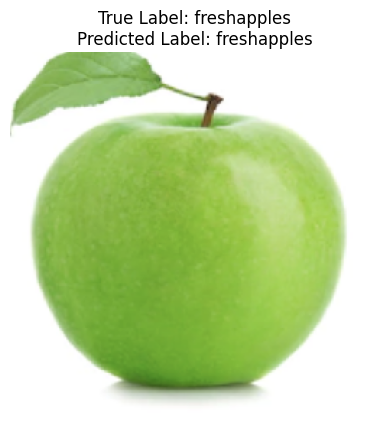

1/1 [==============================] - 0s 55ms/step


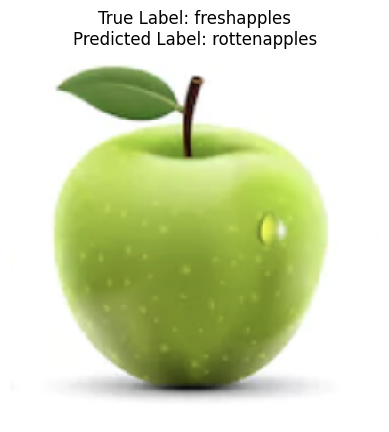

1/1 [==============================] - 0s 65ms/step


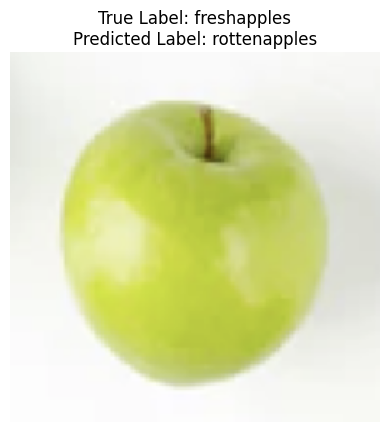

1/1 [==============================] - 0s 61ms/step


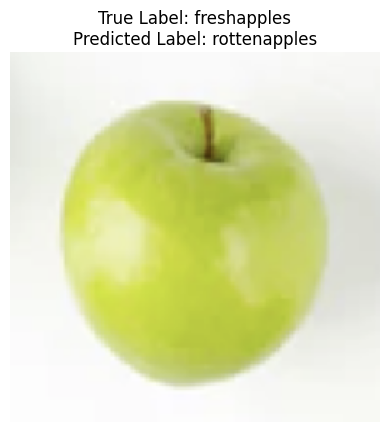

1/1 [==============================] - 0s 60ms/step


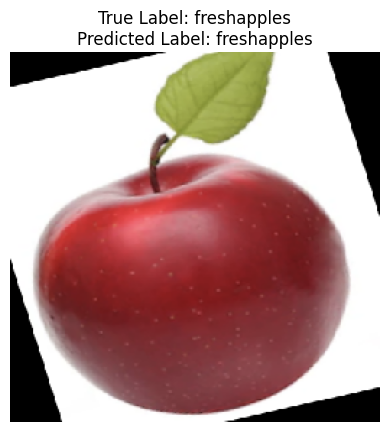

1/1 [==============================] - 0s 60ms/step


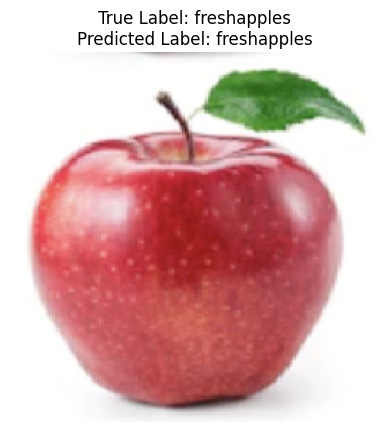

1/1 [==============================] - 0s 78ms/step


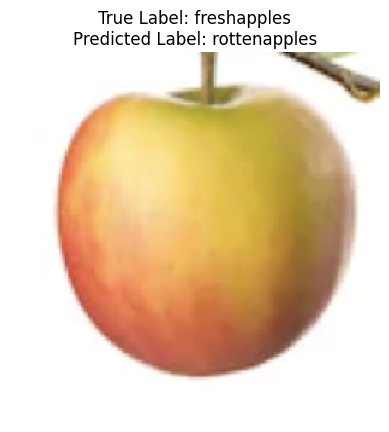

In [ ]:
# Display some randomly selected images along with their true and predicted labels


num_images_to_display = 10
random_indices = np.random.choice(len(test_generator), num_images_to_display)

for index in random_indices:
    # Load and preprocess the image
    img_path = test_generator.filepaths[index]
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make the prediction
    prediction = baseline.predict(img_array)
    predicted_class = np.argmax(prediction[0])

    # Get the true and predicted class labels
    true_label = class_names[true_labels[index]]
    predicted_label = class_names[predicted_class]

    # Plot the image along with the true and predicted labels
    plt.imshow(img)
    plt.title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 60ms/step


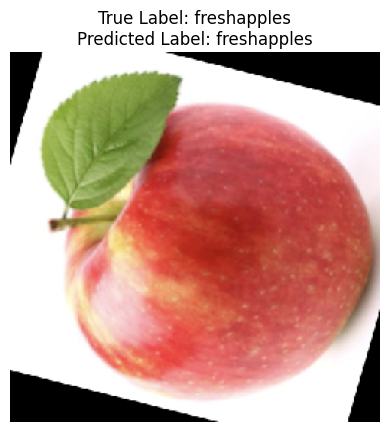

1/1 [==============================] - 0s 76ms/step


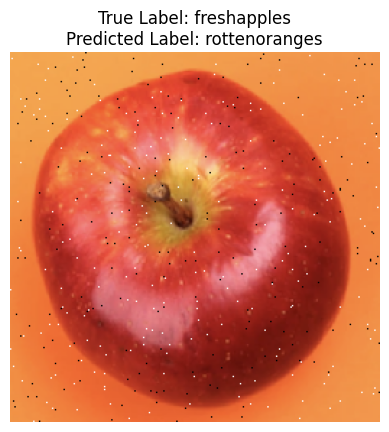

1/1 [==============================] - 0s 74ms/step


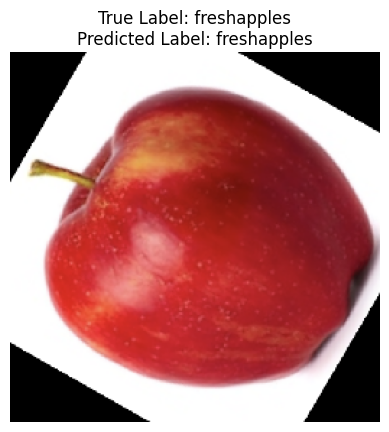

1/1 [==============================] - 0s 62ms/step


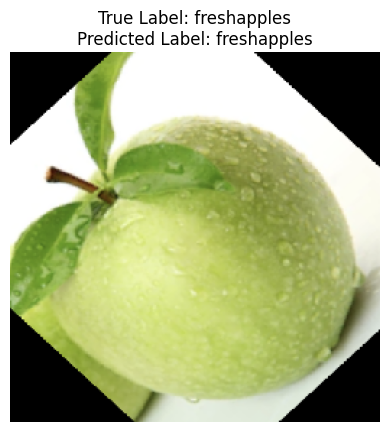

1/1 [==============================] - 0s 60ms/step


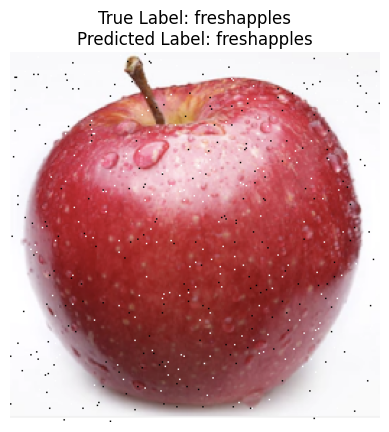

1/1 [==============================] - 0s 71ms/step


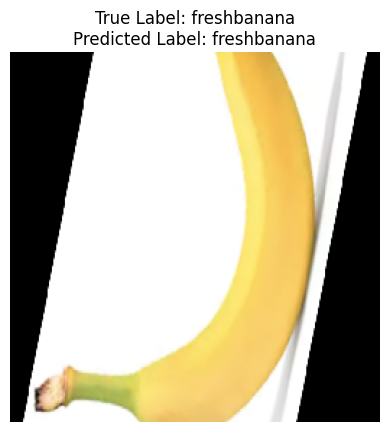

1/1 [==============================] - 0s 63ms/step


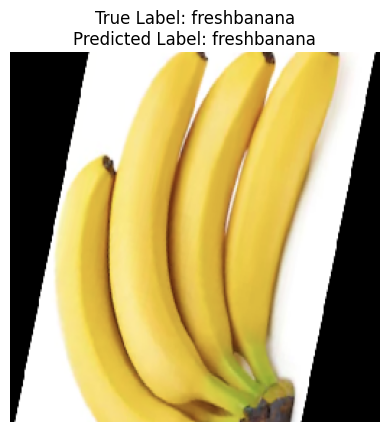

1/1 [==============================] - 0s 71ms/step


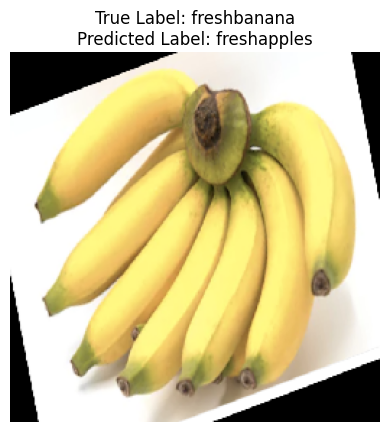

1/1 [==============================] - 0s 66ms/step


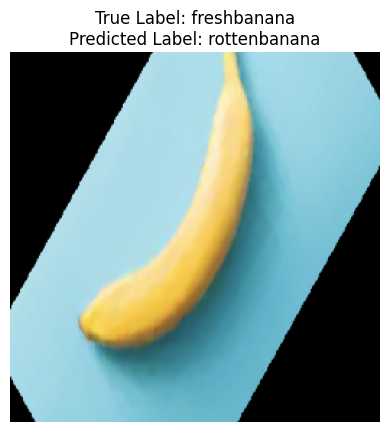

1/1 [==============================] - 0s 64ms/step


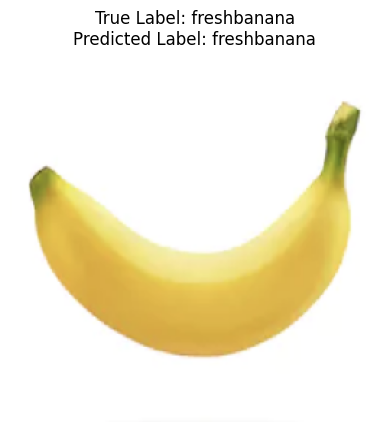

1/1 [==============================] - 0s 90ms/step


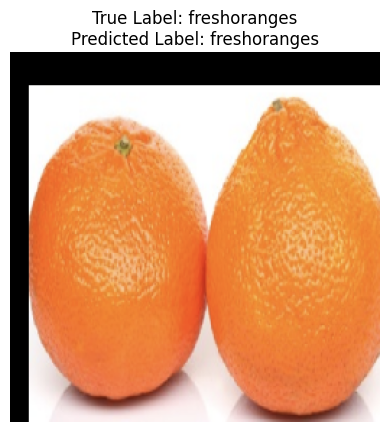

1/1 [==============================] - 0s 72ms/step


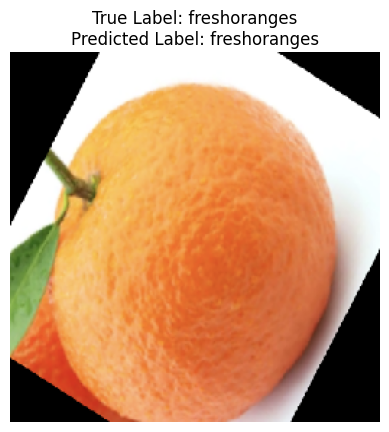

1/1 [==============================] - 0s 123ms/step


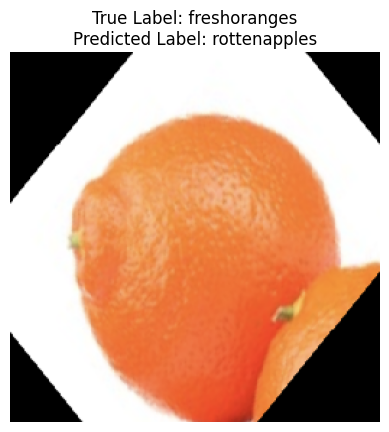

1/1 [==============================] - 0s 113ms/step


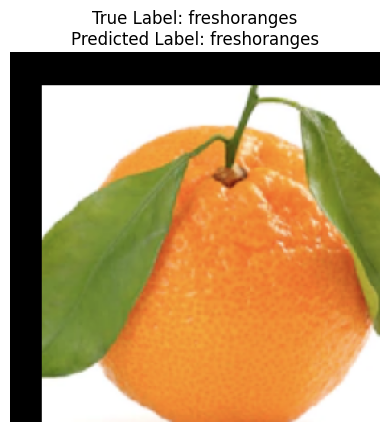

1/1 [==============================] - 0s 104ms/step


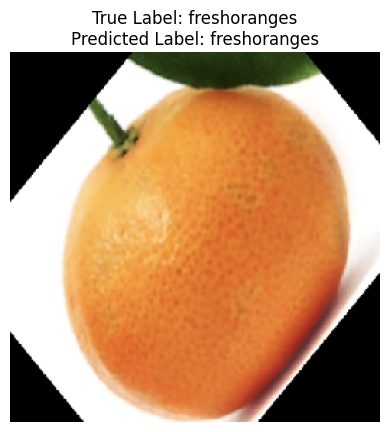

1/1 [==============================] - 0s 98ms/step


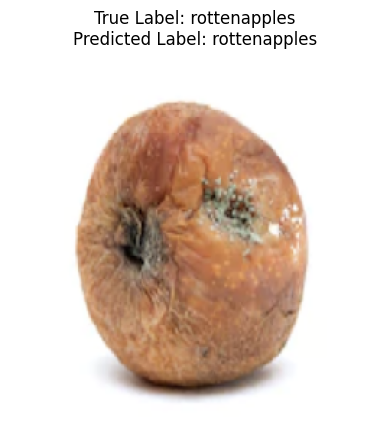

1/1 [==============================] - 0s 99ms/step


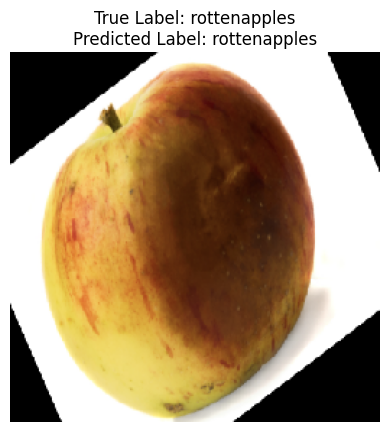

1/1 [==============================] - 0s 121ms/step


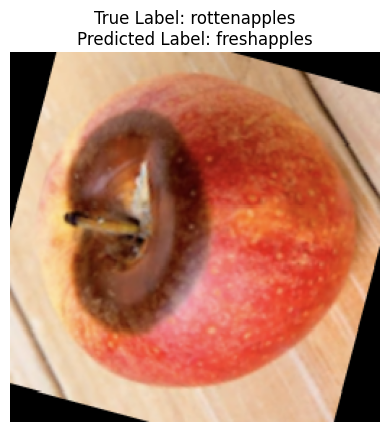

1/1 [==============================] - 0s 104ms/step


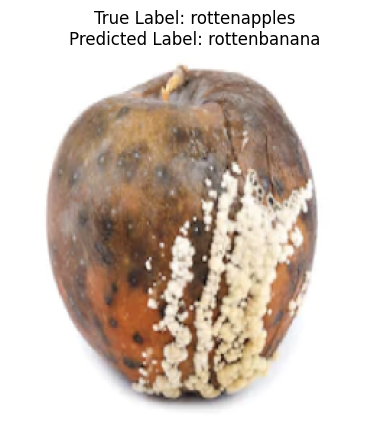

1/1 [==============================] - 0s 140ms/step


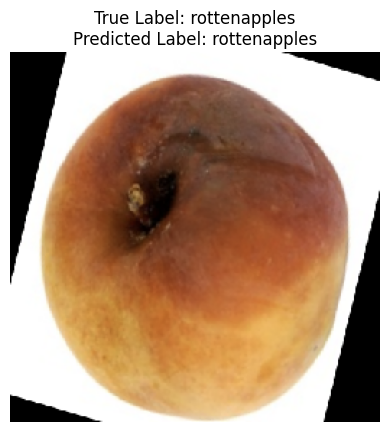

1/1 [==============================] - 0s 90ms/step


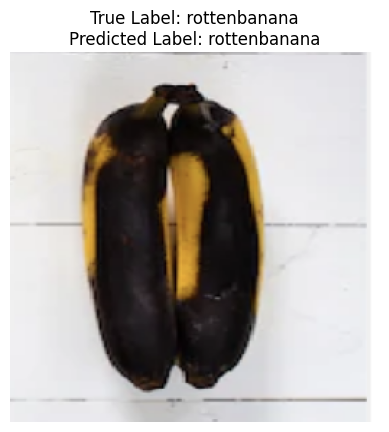

1/1 [==============================] - 0s 91ms/step


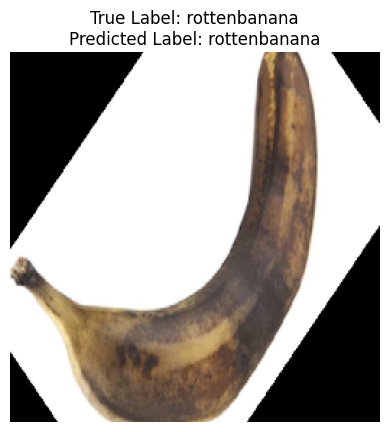

1/1 [==============================] - 0s 125ms/step


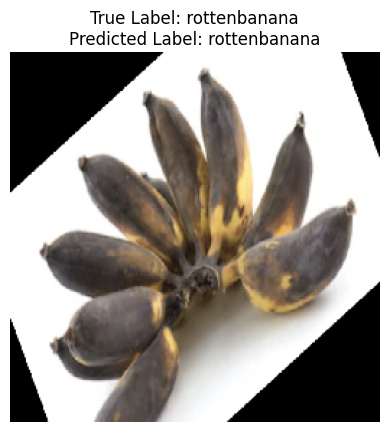

1/1 [==============================] - 0s 111ms/step


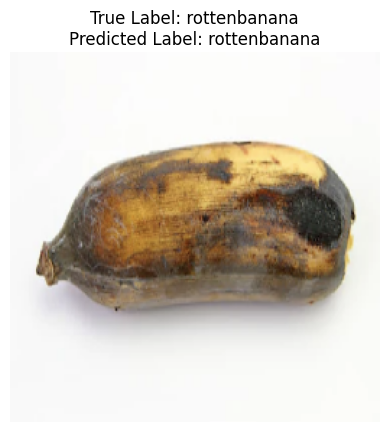

1/1 [==============================] - 0s 95ms/step


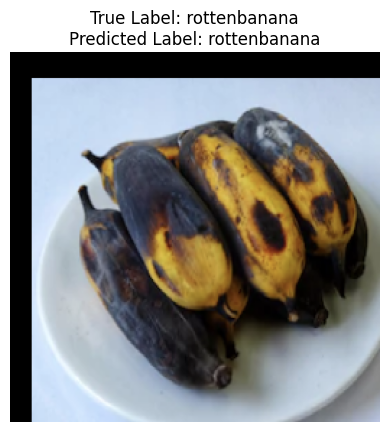

1/1 [==============================] - 0s 80ms/step


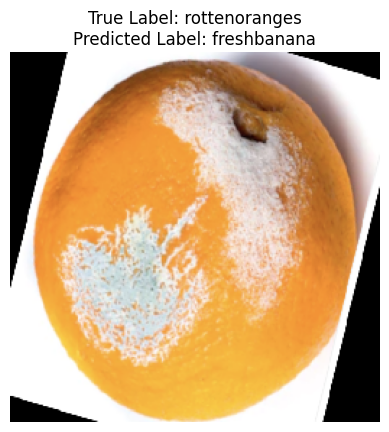

1/1 [==============================] - 0s 86ms/step


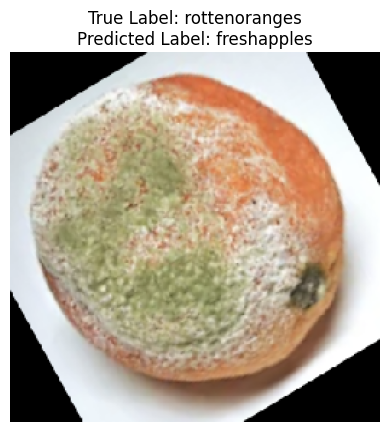

1/1 [==============================] - 0s 78ms/step


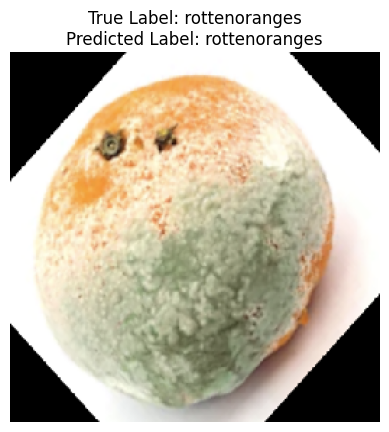

1/1 [==============================] - 0s 77ms/step


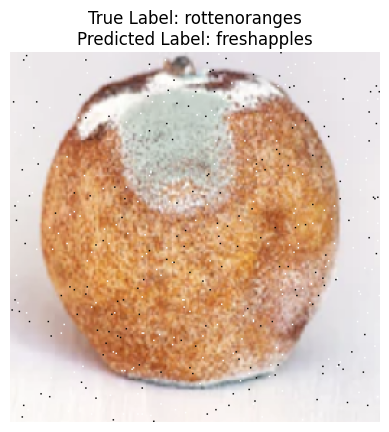

1/1 [==============================] - 0s 112ms/step


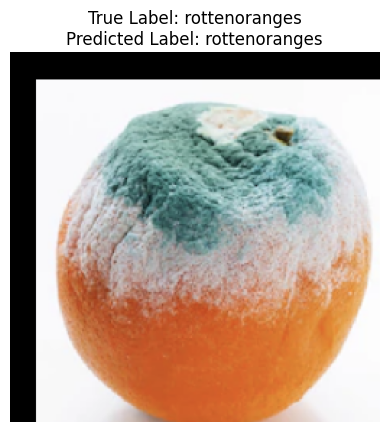

In [ ]:




# Make predictions on the test data
test_predictions = baseline.predict(test_generator)
predicted_classes = np.argmax(test_predictions, axis=1)

# Get the true labels from the test data generator
true_labels = test_generator.classes

# Get the class names from the test data generator
class_names = list(test_generator.class_indices.keys())

# Create lists to store the indices of images for each class
class_indices_lists = [[] for _ in range(len(class_names))]

# Populate the class_indices_lists with the indices of images for each class
for i, label in enumerate(true_labels):
    class_indices_lists[label].append(i)

# Display some randomly selected images from each class along with their true and predicted labels
num_images_to_display = 5

for i, class_name in enumerate(class_names):
    random_indices = np.random.choice(class_indices_lists[i], num_images_to_display)

    for index in random_indices:
        # Load and preprocess the image
        img_path = test_generator.filepaths[index]
        img = image.load_img(img_path, target_size=(256, 256))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make the prediction
        prediction = baseline.predict(img_array)
        predicted_class = np.argmax(prediction[0])

        # Get the true and predicted class labels
        true_label = class_names[true_labels[index]]
        predicted_label = class_names[predicted_class]

        # Plot the image along with the true and predicted labels
        plt.imshow(img)
        plt.title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
        plt.axis('off')
        plt.show()


In [ ]:


# Create the model
baseline2 = Sequential()

# Convolutional layers
baseline2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
baseline2.add(MaxPooling2D((2, 2)))
baseline2.add(BatchNormalization())

baseline2.add(Conv2D(64, (3, 3), activation='relu'))
baseline2.add(MaxPooling2D((2, 2)))
baseline2.add(BatchNormalization())

baseline2.add(Conv2D(128, (3, 3), activation='relu'))
baseline2.add(MaxPooling2D((2, 2)))
baseline2.add(BatchNormalization())

# Flatten the output
baseline2.add(Flatten())

# Dense layers with dropout and L2 regularization
baseline2.add(Dense(128, activation='relu', kernel_regularizer=L2(0.001)))
baseline2.add(Dropout(0.5))  # Adding dropout for regularization

baseline2.add(Dense(64, activation='relu', kernel_regularizer=L2(0.001)))
baseline2.add(Dropout(0.5))  # Adding dropout for regularization

# Output layer
baseline2.add(Dense(6, activation='softmax'))

# Compile the model with custom learning rate

baseline2.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])




In [ ]:
baseline2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                        

In [ ]:
# Hyperparameter Tuning
batch_size = 32
epochs = 20

# Learning Rate Scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with Learning Rate Scheduling and Early Stopping
history = baseline2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[reduce_lr, early_stop],
    batch_size=batch_size
)


Epoch 1/20
273/273 [==============================] - 189s 644ms/step - loss: 5.7256 - accuracy: 0.2797 - val_loss: 2.9693 - val_accuracy: 0.3297 - lr: 0.0010
Epoch 2/20
273/273 [==============================] - 176s 645ms/step - loss: 3.1817 - accuracy: 0.2388 - val_loss: 2.9320 - val_accuracy: 0.2475 - lr: 0.0010
Epoch 3/20
273/273 [==============================] - 179s 655ms/step - loss: 3.1111 - accuracy: 0.2498 - val_loss: 2.8378 - val_accuracy: 0.2612 - lr: 0.0010
Epoch 4/20
273/273 [==============================] - 175s 640ms/step - loss: 2.9673 - accuracy: 0.2356 - val_loss: 2.9323 - val_accuracy: 0.3214 - lr: 0.0010
Epoch 5/20
273/273 [==============================] - 175s 641ms/step - loss: 2.8035 - accuracy: 0.2247 - val_loss: 2.5292 - val_accuracy: 0.2782 - lr: 0.0010
Epoch 6/20
273/273 [==============================] - 176s 645ms/step - loss: 2.5045 - accuracy: 0.2406 - val_loss: 2.3554 - val_accuracy: 0.3255 - lr: 0.0010
Epoch 7/20
273/273 [==========================

In [ ]:
# Evaluate the model on the test data
test_results2 = baseline2.evaluate(test_generator)
test_results2

85/85 [==============================] - 13s 154ms/step - loss: 1.4096 - accuracy: 0.5256


[1.4096163511276245, 0.5255745053291321]

In [ ]:
# The evaluate() method returns the test loss and test accuracy
test_loss2 = test_results2[0]
test_accuracy2 = test_results2[1]

print(f'Test Loss: {test_loss2:.4f}')
print(f'Test Accuracy: {test_accuracy2:.4f}')


Test Loss: 1.4096
Test Accuracy: 0.5256


Let's create more complex Convolutional Neural Network (CNN).

We will use **L1** (Lasso Regularization) this echnique can help us to prevent overfitting by adding a penalty to the loss function based on the size of the weights. Here L1 regularization will make the weigh of the less important features zero. <br> Sequential constractor in Keras creates linear stack of layers. So data will flow from input to output. Now let's add layers to it.
<br> First we are adding a Convolutional layer. 2D is convolution happening in 2 dimensions. So here we have 32 output filters in the convolution. (32 feature detector). Also (3,3) is the size of 2D convolution window what we call it kernel size. <br> **activation = 'relu'** specifying that activation function to be ReLu (Rectified Linear Unit). This way we hav non-linearity which network learn from backpropagation and learns more complex patterns. <br> **input_shape** = (256,256, 3) input images will be 255x255 and 3 color channels. <br> Convolutional layers are effective for image recognition. Kernel slides accross the image and network learn patterns. Number of filters and sizes can be adjusted depending of the problem we want to solve.


Adding **MaxPooling2D** layer to model. MaxPooling reduces the dimensionality of images so it reduces the number of pixels. This way we reduce number of parameters thus computation in the network. We have here (2,2) window. MaxPooling2D layer reduces dimension by taking a maximum value over a 2x2 window during slide.

Adding **Flatten** layer. This layer reshapes multi_dimensional input tensors to single dimension. So creates one dimensional vector. After that we can add fully connected Dense layer. Network will take this layer and perform classification. <br> Adding **Dense** layer (fully connected layer) with 128 number of neurons. <br> Adding **Dropout** layer to our sequential model. 0.5 is a fraction for input units to be dropped. Here approximately half of the neurons in the layer will be turned off each update step during training. <br> **Output layer** Dense(6,...) Here we have 6 neurons. This is final layer so 6 coresponds to number of classes. In our case we have 6 classes to predict. activation = 'softmax' we will use for this layer, because we have multi-class classification. It produces some dimentional vector with values between 0 and 1 which add up to 1. Output of this layer will be probabilities of each of the 6 classes. Class which have highest probability is the most likely class.

Next we define optimizer **Adam AdaptiveMomentEstimation** one of the commonly used otimizer. Optimizer updates weights based on gradients of the loss function. Learning rate choosen to determine size of the steps. Also epsilon choosen to prevent division by zero. <br> Compile the model is necessary step before training the model. We specify loss function that model will use to evaluate how well it is doing intrainig data. The model goal is to minimize this loss. accuracy is choosen to compute which is the proportion of correctly classified instances.

Then we **compile** the model. Comiling is necessary step before training model. **loss** function model will use to evaluate how well is doing on the training data. Model goal is to minimize this loss. **Metrics** is list of metrics in our case **accuracy** which model will compute during training process. Accuracy is the proportion of correctly classified instances. After each epoch it will compute and report specified metrics.

In [ ]:
reg = L1(0.00001)

# Create the model
baseline3 = Sequential()

# Convolutional layers
baseline3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
# Adding BatchNormalization layer to model
baseline3.add(BatchNormalization())
# Adding MaxPooling2D layer to reduce dimension
baseline3.add(MaxPooling2D((2, 2)))
# Adding another 2 dimensional convolutionla layer to the sequential model
baseline3.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer = reg))
baseline3.add(BatchNormalization())
baseline3.add(MaxPooling2D((2, 2)))
baseline3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer = reg))
baseline3.add(BatchNormalization())
baseline3.add(MaxPooling2D((2, 2)))

# Flatten the output
baseline3.add(Flatten())

# Dense layers with dropout and l2 regularization
baseline3.add(Dense(128, activation='relu', kernel_regularizer = reg))
baseline3.add(Dropout(0.5))
baseline3.add(Dense(64, activation='relu', kernel_regularizer = reg))

# Output layer
baseline3.add(Dense(6, activation='softmax'))

# Compile the model with custom learning rate
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-05)

baseline3.compile(loss='categorical_crossentropy',
                  optimizer = opt,
                  metrics=['accuracy'])




The **summary()** function will print <br> layers and their orders <br> output shapes of each layer <br> number of parameters in each layer <br>  


In [ ]:
# getting summary of the architecture of sequential model
baseline3.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_22 (Bat  (None, 254, 254, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_23 (Bat  (None, 125, 125, 64)     256       
 chNormalization)                                                
                                                     

Total numbers of trainable parameters are 14,848,518. Non-trainable parameters are 448 which are parameters like moving mean and variance in BatchNormalization layer.

In [ ]:
len(train_generator)

273

In [ ]:
len(validation_generator)

69

Now we will train our model. <br> **epoch** is the number of times the entire training dataset will be passed forward and backward through the network. **batch_size** is the number of training examples used in one iteration. <br>
**Learning Rate Scheduling** this callback reduces the learning rate when the validation los stops improving. Reducing or modifying learning rate during training can help to reach global minimum of the loss function.<br> **Early Stopping** is used to stop training when monitored metric in this case accuracy stopped improving. **Model Training** is a fit process. **train_generator** and **validation_generator** are training and validation datasets. <br> **steps_per_epoch** is the total number of steps before declaring one epoch. Usually it is total number of samples in train dataset divided by the batch size. Here we don't divide it because we did it in train generator. **validation_steps** is the total number of steps to draw from validation generator after every epoch.

In [ ]:
# Hyperparameter Tuning
epochs = 50
batch_size = 32

# Learning Rate Scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)  # to reduce learning rate ?

# Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model with Learning Rate Scheduling and Early Stopping
history = baseline3.fit(
    train_generator,
    steps_per_epoch = len(train_generator),
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = len(validation_generator),
    callbacks = [reduce_lr, early_stop],
    batch_size = batch_size
)







Epoch 1/50
273/273 [==============================] - 171s 613ms/step - loss: 1.8362 - accuracy: 0.6274 - val_loss: 7.2656 - val_accuracy: 0.2406 - lr: 1.0000e-04
Epoch 2/50
273/273 [==============================] - 171s 627ms/step - loss: 1.3775 - accuracy: 0.7511 - val_loss: 1.2916 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 3/50
273/273 [==============================] - 177s 648ms/step - loss: 1.2719 - accuracy: 0.7830 - val_loss: 0.9319 - val_accuracy: 0.8848 - lr: 1.0000e-04
Epoch 4/50
273/273 [==============================] - 174s 637ms/step - loss: 1.1914 - accuracy: 0.8095 - val_loss: 0.9150 - val_accuracy: 0.8829 - lr: 1.0000e-04
Epoch 5/50
273/273 [==============================] - 172s 632ms/step - loss: 1.1143 - accuracy: 0.8330 - val_loss: 0.9289 - val_accuracy: 0.8866 - lr: 1.0000e-04
Epoch 6/50
273/273 [==============================] - 174s 636ms/step - loss: 1.0529 - accuracy: 0.8480 - val_loss: 0.8072 - val_accuracy: 0.9252 - lr: 1.0000e-04
Epoch 7/50
273/273 [==

In [ ]:
# Evaluate the model on the test data
test_results_3 = baseline3.evaluate(test_generator)

# The evaluate() method returns the test loss and test accuracy
test_loss_3 = test_results_3[0]
test_accuracy_3 = test_results_3[1]

print(f'Test Loss: {test_loss_3:.4f}')
print(f'Test Accuracy: {test_accuracy_3:.4f}')


85/85 [==============================] - 11s 130ms/step - loss: 0.5841 - accuracy: 0.9707
Test Loss: 0.5841
Test Accuracy: 0.9707


85/85 [==============================] - 12s 134ms/step


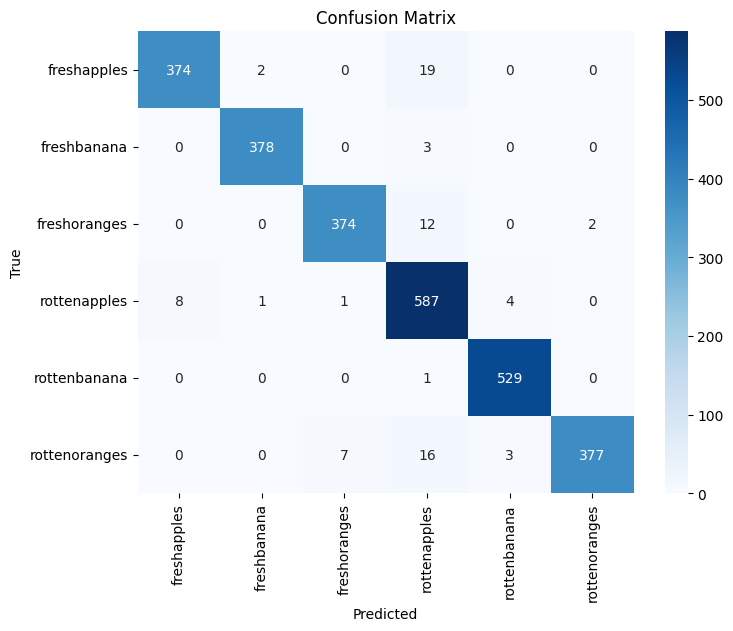

In [ ]:
# Make predictions on the test data
test_predictions = baseline3.predict(test_generator)
predicted_classes = np.argmax(test_predictions, axis=1)

# Get the true labels from the test data generator
true_labels = test_generator.classes

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Get the class names from the test data generator
class_names = list(test_generator.class_indices.keys())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


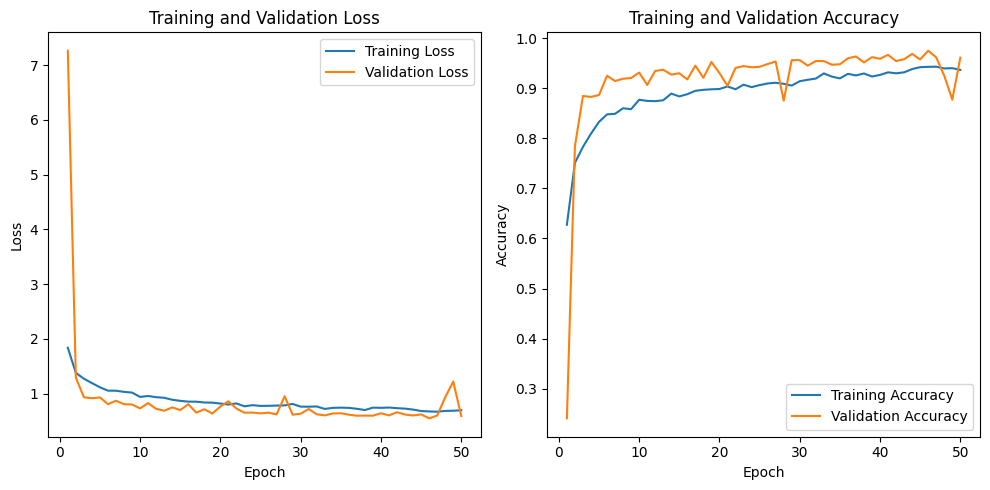

In [ ]:
# Get training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get training and validation accuracy values
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot the accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


In [ ]:
import pickle

# Save the model to Google Drive
model_filename = '/content/drive/MyDrive/Colab Files/baseline3_model.h5'
baseline3.save(model_filename)

# Save the history to Google Drive
history_filename = '/content/drive/MyDrive/Colab Files/baseline3_history.pkl'
with open(history_filename, 'wb') as file:
    pickle.dump(history.history, file)


In [ ]:
# Save the model to Colab's local storage
model_filename = '/content/baseline3_model.h5'
baseline3.save(model_filename)

# Save the history to Colab's local storage
history_filename = '/content/baseline3_history.pkl'
with open(history_filename, 'wb') as file:
    pickle.dump(history.history, file)


In [ ]:
from tensorflow.keras.models import load_model
import pickle

# Load the model
model_filename = '/content/drive/MyDrive/Colab Files/baseline3_model.h5'
loaded_model = load_model(model_filename)

# Load the history
history_filename = '/content/drive/MyDrive/Colab Files/baseline3_history.pkl'
with open(history_filename, 'rb') as file:
    loaded_history = pickle.load(file)


The evaluate() method evaluates the performance of the model in test data which is test_generator data. The method returns list where first element is overall loss and second element is accuracy.

In [ ]:
# Evaluate the model on the test data
test_results_3 = loaded_model.evaluate(test_generator)

# The evaluate() method returns the test loss and test accuracy
test_loss_3 = test_results_3[0]
test_accuracy_3 = test_results_3[1]

print(f'Test Loss: {test_loss_3:.4f}')
print(f'Test Accuracy: {test_accuracy_3:.4f}')


85/85 [==============================] - 15s 175ms/step - loss: 0.5841 - accuracy: 0.9707
Test Loss: 0.5841
Test Accuracy: 0.9707


Here predict() function is used to generate prediction. The output of prediction is numpy array. Shape is nuber of samples in test set and number of classes in output. The values are probabilities, each value indicate probability of that sample belongin to a particular class.

In [ ]:
# Make predictions on the test data
test_predictions = loaded_model.predict(test_generator)
test_predictions

85/85 [==============================] - 979s 12s/step


array([[1.00000000e+00, 6.25418392e-25, 4.95925903e-32, 1.64177158e-10,
        2.55749477e-33, 6.78257457e-29],
       [1.00000000e+00, 3.12363665e-19, 8.50761545e-28, 7.73571263e-10,
        3.04288611e-26, 1.25488295e-24],
       [9.86191392e-01, 8.28437169e-06, 1.02712079e-08, 1.37998257e-02,
        5.87446266e-07, 1.97882315e-08],
       ...,
       [6.10217083e-20, 1.41142945e-18, 2.20937550e-14, 3.56947007e-11,
        9.94991935e-17, 1.00000000e+00],
       [2.27445741e-33, 9.64823263e-27, 1.97088101e-14, 1.54843655e-20,
        4.08705957e-22, 1.00000000e+00],
       [1.37738621e-08, 1.19582015e-08, 8.91175368e-05, 8.76939371e-02,
        2.86497617e-08, 9.12216902e-01]], dtype=float32)

np.argmax returns index of maximum value in array, axis = 1 finds maximum value alond each row.

In [ ]:
predicted_classes = np.argmax(test_predictions, axis=1)
predicted_classes

array([0, 0, 0, ..., 5, 5, 5])

Attribute **.classes** provides class labels as a one dimensional array that identifies class of each image in our dataset. Class labels are sorted by alphanumeric order as folder names in our directory. They assigned to our images based on sudirectory in which images are located. Like test folder has 6 subfolders. (so labels are from 0_5). If we print **true_labels** we will see class labels for all images by the sam order as they are in the dataset.

In [ ]:
# Get the true labels from the test data generator
true_labels = test_generator.classes
true_labels

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

Let's output dictionary to see how class names correspond to numerical labels.

In [ ]:
test_generator.class_indices

{'freshapples': 0,
 'freshbanana': 1,
 'freshoranges': 2,
 'rottenapples': 3,
 'rottenbanana': 4,
 'rottenoranges': 5}

In [ ]:
# Get the class names from the test data generator
class_names = list(test_generator.class_indices.keys())
class_names

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

let's use **confusion_matrix** function from sklearn.metrics module to return a confusion matrix which will allow us to visualize performance of algorithm.

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)
cm

array([[374,   2,   0,  19,   0,   0],
       [  0, 378,   0,   3,   0,   0],
       [  0,   0, 374,  12,   0,   2],
       [  8,   1,   1, 587,   4,   0],
       [  0,   0,   0,   1, 529,   0],
       [  0,   0,   7,  16,   3, 377]])

This plot will show where the models predictions are correct which is diagonal elements in matrix and will show where the model has mistaken off diagonal elements. Darkervthe color higher the number of inctances.

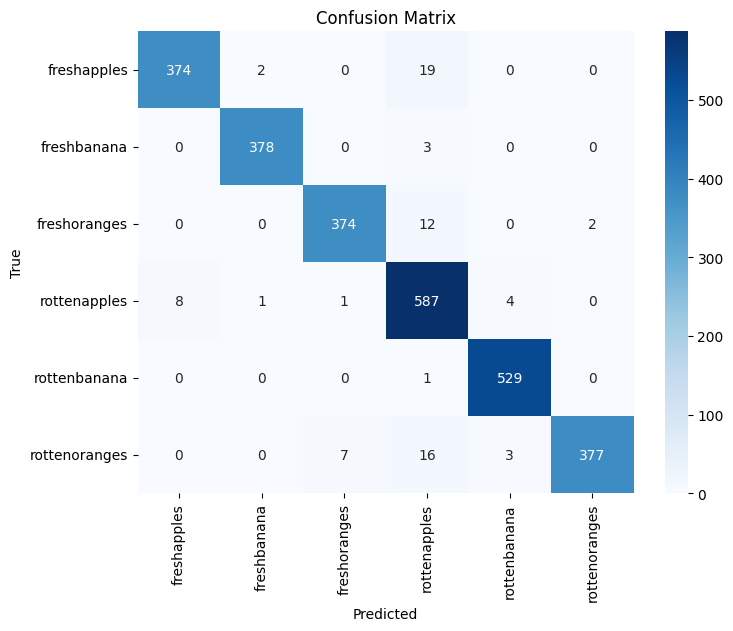

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**classification_report** function from sklearn.metrics modulemwill show text report to show main classification metrics.  <br> **Precission** this is ability of classifier not to label sample positive the is negative. **Recall(sensitivity)**  this is ability of classifier to find all positive samples. **F1-score** this is weighted mean of precission and recall. **Support** is number of samples of true response.

In [ ]:
# Print the classification report
print(classification_report(true_labels, predicted_classes, target_names=class_names))

               precision    recall  f1-score   support

  freshapples       0.98      0.95      0.96       395
  freshbanana       0.99      0.99      0.99       381
 freshoranges       0.98      0.96      0.97       388
 rottenapples       0.92      0.98      0.95       601
 rottenbanana       0.99      1.00      0.99       530
rottenoranges       0.99      0.94      0.96       403

     accuracy                           0.97      2698
    macro avg       0.98      0.97      0.97      2698
 weighted avg       0.97      0.97      0.97      2698



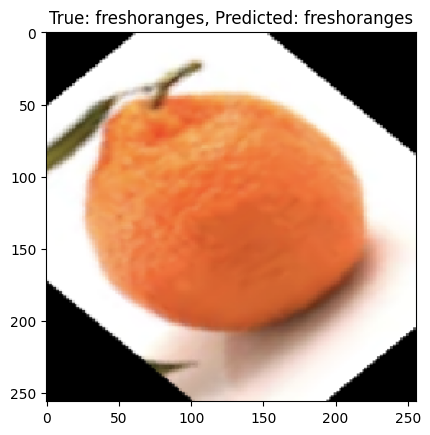

In [ ]:


# Choose a random batch from the test data
batch_num = np.random.choice(len(test_generator), 1)[0]
batch = test_generator[batch_num]

# Choose a random image from the chosen batch
img_num = np.random.choice(batch[0].shape[0], 1)[0]
img = batch[0][img_num]

# Get the true and predicted labels for this image
true_label = class_names[np.argmax(batch[1][img_num])]
predicted_label = class_names[np.argmax(test_predictions[batch_num * test_generator.batch_size + img_num])]

# Display the image along with its true and predicted labels
plt.imshow(img)
plt.title(f"True: {true_label}, Predicted: {predicted_label}")
plt.show()


IndexError: ignored

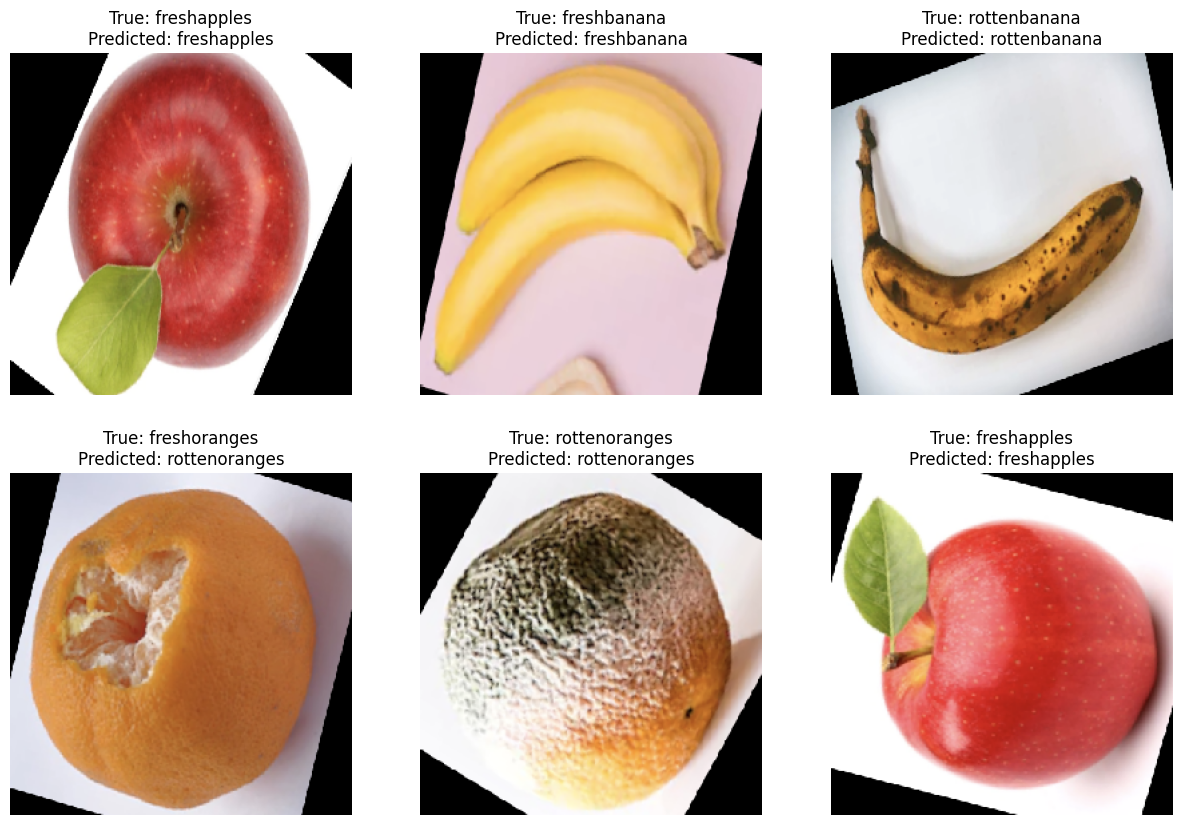

In [ ]:


fig, axes = plt.subplots(2, 3, figsize=(15,10)) # Set up a 2x3 grid of subplots
axes = axes.ravel() # Flatten the axes array



for i in np.arange(0, 8): # Generate 6 images

    # Choose a random batch from the test data
    batch_num = np.random.choice(len(test_generator), 1)[0]
    batch = test_generator[batch_num]

    # Choose a random image from the chosen batch
    img_num = np.random.choice(batch[0].shape[0], 1)[0]
    img = batch[0][img_num]

    # Get the true and predicted labels for this image
    true_label = class_names[np.argmax(batch[1][img_num])]
    predicted_label = class_names[np.argmax(test_predictions[batch_num * test_generator.batch_size + img_num])]

    # Display the image along with its true and predicted labels
    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5) # Add some space between the subplots
